# | Data Science for Finance | Fixed Income
#### Student: Thiago Bellas  | Student Id: 20231131 |

## INDIVIDUAL PROJECT DESCRIPTION

### Load data transforming the data to use in the exercises below

Consider the Bloomberg information on a 25-year fixed rate receiver interest rate swap (IRS) contract issued on 19-01-2007 with floating leg linked to EURIBOR 6-month rate.

In [1]:
#!pip install quantlib
#!pip install tabula-py
#!pip install jpype1

In [2]:
# Import initial libraries
import QuantLib as ql
import numpy as np
import pandas as pd

In [3]:
# Function to work with temporal series using days and years
def count_days(d1: ql.Date, d2: ql.Date, basis = ql.Actual360()):
    return basis.dayCount(d1, d2)

def count_years(d1: ql.Date, d2: ql.Date, basis = ql.Actual360()):
    return basis.yearFraction(d1, d2)

def get_coupon_dates(issue_date:ql.Date, maturity_date: ql.Date, frequency: int):
    schedule = ql.Schedule(
        issue_date, 
        maturity_date, 
        ql.Period(frequency),
        ql.TARGET(),
        ql.Following,
        ql.Following,
        ql.DateGeneration.Backward, 
        False
    )
    return [dt for dt in schedule]

#### Consider the Bloomberg reference EUR yield curve on the valuation date 14-04-2019 as detailed below. Based on the market information:

In [4]:
import pandas as pd

# Load the data from the Excel file
yield_curve_df = pd.read_excel('Bloomberg reference EUR yield curve.xlsx')

In [5]:
yield_curve_df.columns

Index(['Maturity Date', 'Market Rate %'], dtype='object')

In [6]:
# rename columns to actually be useful later on...
yield_curve_df.rename(columns = {"Maturity Date":"maturity", "Market Rate %": "rate"}, inplace=True)

In [7]:
yield_curve_df

,maturity,rate
0,2019-04-15,-0.364000
1,2019-04-23,-0.378000
2,2019-05-16,-0.367000
3,2019-07-16,-0.310000
4,2019-10-16,-0.232000
5,2020-04-16,-0.227000
6,2020-10-16,-0.191000
7,2021-04-16,-0.199250
8,2022-04-19,-0.130500
9,2023-04-17,-0.039750


In [8]:
#Store valuation date as variable
valuation_date = ql.Date(14,4,2019)

In [9]:
# apply some operations for changhing index and rate (divide by 100 to be used as-is)
yield_curve_df['maturity'] = yield_curve_df['maturity'] \
    .apply(lambda d: pd.to_datetime(d, infer_datetime_format=True)) \
    .apply(lambda d: ql.Date(d.day, d.month, d.year))

In [10]:
yield_curve_df['rate'] = yield_curve_df['rate'].apply(lambda r: r/100)

In [11]:
yield_curve_df['theta'] = yield_curve_df['maturity'] \
    .apply(lambda maturity: count_years(valuation_date, maturity))

In [12]:
yield_curve_df

,maturity,rate,theta
0,"April 15th, 2019",-0.003640,0.002778
1,"April 23rd, 2019",-0.003780,0.025000
2,"May 16th, 2019",-0.003670,0.088889
3,"July 16th, 2019",-0.003100,0.258333
4,"October 16th, 2019",-0.002320,0.513889
5,"April 16th, 2020",-0.002270,1.022222
6,"October 16th, 2020",-0.001910,1.530556
7,"April 16th, 2021",-0.001992,2.036111
8,"April 19th, 2022",-0.001305,3.058333
9,"April 17th, 2023",-0.000398,4.066667


After pre-processing this dataset is ready to implement methods like Linear and Cubic Spline to interpolate the yield curve, where the rate is y and theta (maturity versus observation date) is x

### a) Build the complete yield curve using interpolation techniques.

#### Cubic Spline interpolation

In [13]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

#cubic spline the yield curve
yield_curve = CubicSpline(yield_curve_df.theta, yield_curve_df.rate, bc_type='not-a-knot')

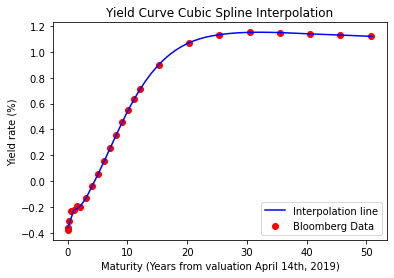

In [14]:
time_axis = np.arange(0, max(yield_curve_df.theta)+1)
rate_axis = yield_curve(time_axis)

plt.scatter(yield_curve_df.theta, yield_curve_df.rate * 100, label='Bloomberg Data', color='red');
plt.plot(time_axis, rate_axis * 100, label='Interpolation line', color='blue');
plt.xlabel(f'Maturity (Years from valuation {valuation_date})')
plt.ylabel('Yield rate (%)')
plt.title('Yield Curve Cubic Spline Interpolation')
plt.legend()
plt.show()

In [17]:
rate_axis

array([-0.00361191, -0.0022682 , -0.00198577, -0.00136338, -0.00045646,
        0.00047491,  0.00144861,  0.00245599,  0.00345127,  0.0044418 ,
        0.00538658,  0.00624917,  0.00703217,  0.00773343,  0.00835336,
        0.00889653,  0.00936764,  0.00977219,  0.01011613,  0.01040539,
        0.0106459 ,  0.01084355,  0.01100387,  0.01113218,  0.01123379,
        0.01131399,  0.01137795,  0.01142861,  0.01146733,  0.01149542,
        0.01151418,  0.01152493,  0.01152875,  0.01152651,  0.01151911,
        0.01150743,  0.01149234,  0.01147468,  0.01145527,  0.01143489,
        0.01141434,  0.01139442,  0.01137546,  0.01135721,  0.0113394 ,
        0.01132176,  0.011304  ,  0.01128586,  0.01126706,  0.01124731,
        0.01122636,  0.01120391])

### b) Compute the accrued interest in the fixed and floating legs of the contract.

We assume T+0 lag on settlement date (settlement date = trade date) and notional value of 10 million euros. We can start by defining common vars:

#### Set the assumptions

In [23]:
settlement_date = ql.Date(15, 4, 2019)
issue_date = ql.Date(19,1, 2007)
maturity_date = ql.Date(19, 1, 2032)
notional_value = 10e6
swap_rate = fixed_rate = 0.05982 / 100

#### Fixed the leg

In [24]:
#we actually exclude the first coupon, because it's a short first coupon since we settled at 15/4/2019
#and first coupon after settlement is at 20/1/2019
fixed_leg_coupon_dates = [
    date for date in get_coupon_dates(issue_date, maturity_date, 1) 
    if date.year() >= settlement_date.year()
]

#Fixed leg is set at 30U/360
fixed_leg_basis = ql.Thirty360(ql.Thirty360.BondBasis)
fixed_leg_ai_u = count_days(fixed_leg_coupon_dates[0], settlement_date, fixed_leg_basis)
fixed_leg_ai_w = 360

fixed_leg_ai = notional_value * fixed_leg_ai_u/fixed_leg_ai_w * fixed_rate

#discard first coupon for later
fixed_leg_coupon_dates = fixed_leg_coupon_dates[1:]

print(f"Fixed Leg AI: {fixed_leg_ai}€")
print(f"Fixed Leg AI: {fixed_leg_ai/notional_value * 100}%")

Fixed Leg AI: 1395.8000000000002€
Fixed Leg AI: 0.013958000000000002%


#### Floating leg

In [25]:
#we actually exclude the first coupon, because it's a short first coupon since we settled at 15/4/2019
#and first coupon after settlement is at 20/1/2019
floating_leg_coupon_dates = [
    date for date in get_coupon_dates(issue_date, maturity_date, 2)
    if date.year() >= settlement_date.year()
]

#Floating leg is set at ACT/360
floating_leg_basis = ql.Actual360()
floating_leg_ai_u = count_days(floating_leg_coupon_dates[0], settlement_date, floating_leg_basis)
floating_leg_ai_w = 360/2 #semi annual 360-day year

floating_rate = -0.236 / 100
floating_leg_ai = notional_value * floating_leg_ai_u/floating_leg_ai_w * floating_rate/2

#discard first coupon for later
floating_leg_coupon_dates = floating_leg_coupon_dates[1:]

print(f"Floating Leg AI: {floating_leg_ai}€")
print(f"Floating Leg AI: {floating_leg_ai/notional_value * 100}%")

Floating Leg AI: -5506.666666666666€
Floating Leg AI: -0.05506666666666667%


### c) Calculate the clean (principal) and dirty market value of the swap contract.

#### Function to calculate the cashflows for the fixed leg, where the first coupon will be short

In [32]:
short_discount = count_days(settlement_date, fixed_leg_coupon_dates[0], fixed_leg_basis)/360
print(f"We will received {round(short_discount * 100, 2)}% of the first fixed leg coupon")

We will received 76.39% of the first fixed leg coupon


In [34]:
def get_fixed_leg_payments(rate):
    fixed_leg_cashflows = []
    for i, coupon_date in enumerate(fixed_leg_coupon_dates[::-1]):
        #calculate df
        spot_t = count_years(coupon_date, maturity_date, fixed_leg_basis)
        spot_rate = yield_curve(spot_t)
        df = 1/( (1+spot_rate)**(i+1) )

        coupon = rate * notional_value
        if i == 0: #if first coupon, short discount it
            coupon *= short_discount
        elif i == len(fixed_leg_coupon_dates) - 1:
            coupon += notional_value

        fixed_leg_cashflows.append( coupon * df )
    return fixed_leg_cashflows

fixed_leg_cashflows = get_fixed_leg_payments(fixed_rate)
print(f"Fixed leg payments: {fixed_leg_cashflows}")
fixed_leg_cashflows = np.array(fixed_leg_cashflows)
fixed_leg_pv = fixed_leg_cashflows.sum()
print(f"Fixed leg PV: €{fixed_leg_pv}")

Fixed leg payments: [4586.148102557556, 6009.224118407974, 6017.75539513584, 6014.7345714189005, 5995.671317481784, 5964.982877940192, 5921.691008959212, 5865.88572311122, 5799.356504920386, 5722.669065726947, 5638.745354358597, 5551.111982682253, 9134984.223066304]
Fixed leg PV: €9204072.199089006


In [36]:
print(f"Clean price: {round(fixed_leg_pv/notional_value * 100, 4)}")
print(f"Dirty price: {round((fixed_leg_pv+fixed_leg_ai)/notional_value * 100, 4)}")

Clean price: 92.0407
Dirty price: 92.0547


In [37]:
floating_cf_years = [
    count_years(date, maturity_date, floating_leg_basis) 
    for date in floating_leg_coupon_dates[::-1]
]

floating_cf_rates = yield_curve(floating_cf_years)

euribor_forward_rates = []

for i in range(len(floating_cf_years)-1):
    t_0 = floating_cf_years[i]
    t_1 = floating_cf_years[i+1]
    spot_t0 = floating_cf_rates[i]
    spot_t1 = floating_cf_rates[i+1]

    forward_rate = ( (1+spot_t1)**t_1 )/( (1+spot_t0)**t_0 )
    forward_rate = forward_rate**(1/(t_1-t_0))
    forward_rate = forward_rate - 1

    euribor_forward_rates.append(forward_rate)

euribor_forward_rates = [floating_rate] + euribor_forward_rates

Text(0.5, 0, 'Time (years)')

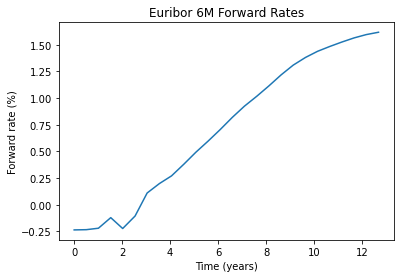

In [38]:
plt.figure();
plt.plot(floating_cf_years, np.array(euribor_forward_rates)*100);
plt.title("Euribor 6M Forward Rates");
plt.ylabel("Forward rate (%)")
plt.xlabel("Time (years)")

In [39]:
float_leg_cashflows = []
for i, coupon_date in enumerate(floating_leg_coupon_dates[::-1]):
    #calculate df
    spot_t = count_years(coupon_date, maturity_date, floating_leg_basis)
    spot_rate = yield_curve(spot_t)
    df = 1/( (1+spot_rate/2)**(i+1) )

    coupon = euribor_forward_rates[i]/2 * notional_value
    if i == 0: #if first coupon, short discount it
        coupon *= short_discount
    elif i == len(fixed_leg_coupon_dates) - 1:
        coupon += notional_value

    float_leg_cashflows.append( coupon * df )

print(f"Float leg payments: {float_leg_cashflows}")
float_leg_cashflows = np.array(float_leg_cashflows)
floating_leg_pv = float_leg_cashflows.sum()
print(f"Float leg PV: €{floating_leg_pv}")

Float leg payments: [-9030.197033170174, -11713.82637970997, -11045.911851302157, -6072.612669374967, -11198.64977943414, -5314.519582586747, 5525.913339528667, 9953.424490584383, 13551.99927948458, 18971.047501456742, 24532.994742802424, 29615.118680293475, 9935680.445623657, 40358.05409402312, 45319.192176604374, 49606.10538156119, 54030.06429402184, 58687.97576320027, 62653.97652290914, 65624.33060114959, 67858.83040088939, 69475.71946704706, 70863.08064074456, 72082.45993336174, 72916.87072127398, 73319.37002480196]
Float leg PV: €10786251.256383818


In [40]:
print(f"Clean price: {round(floating_leg_pv/notional_value * 100, 4)}")
print(f"Dirty price: {round((floating_leg_pv+floating_leg_ai)/notional_value * 100, 4)}")

Clean price: 107.8625
Dirty price: 107.8074


In [41]:
swap_value = fixed_leg_pv-floating_leg_pv
print(f"Swap contract value: €({swap_value})")

Swap contract value: €(-1582179.057294812)


### d) Estimate the net present value of the contract.

In [44]:
# Calculate the present value of future cash flows for both fixed and floating legs
fixed_leg_npv = fixed_leg_pv - fixed_leg_ai
floating_leg_npv = floating_leg_pv - floating_leg_ai

# Net Present Value (NPV) of the contract
net_present_value = fixed_leg_npv - floating_leg_npv

print(f"Fixed Leg NPV: €{fixed_leg_npv}")
print(f"Floating Leg NPV: €{floating_leg_npv}")
print(f"Net Present Value (NPV) of the Contract: €{net_present_value}")


Fixed Leg NPV: €9202676.399089005
Floating Leg NPV: €10791757.923050484
Net Present Value (NPV) of the Contract: €-1589081.5239614788


### e) Estimate the swap par rate.

In [50]:
from scipy.optimize import fsolve

def find_swap_par_rate(fixed_rate):
    return sum(get_fixed_leg_payments(fixed_rate)) - floating_leg_pv

#I'll guess that the swap par rate is around 6% because
#it has to be high enough to compensate for the increasing
#interest rate hikes
swap_par_rate = fsolve(find_swap_par_rate, 6/100)[0]

print(f"The swap par rate is {round(swap_par_rate*100, 4)}%")

The swap par rate is 1.3294%


In [51]:
sum(get_fixed_leg_payments(swap_par_rate)) - floating_leg_pv

0.0

### f) Estimate the following IRS Greeks: present value of a one basis point shift (PV01), DV01, Gamma and discuss the interest rate risk of the contract. 

In [46]:
# Function to calculate the present value for a given yield curve shift
def calculate_present_value(yield_curve_shift):
    # Create a new yield curve with a one basis point shift
    shifted_yield_curve = CubicSpline(yield_curve_df.theta, yield_curve_df.rate + yield_curve_shift, bc_type='not-a-knot')

    # Recalculate fixed and floating leg present values with the shifted yield curve
    fixed_leg_cashflows_shifted = get_fixed_leg_payments(fixed_rate)
    fixed_leg_cashflows_shifted = np.array(fixed_leg_cashflows_shifted)
    fixed_leg_pv_shifted = fixed_leg_cashflows_shifted.sum()

    floating_leg_cashflows_shifted = []
    for i, coupon_date in enumerate(floating_leg_coupon_dates[::-1]):
        spot_t = count_years(coupon_date, maturity_date, floating_leg_basis)
        spot_rate = shifted_yield_curve(spot_t)
        df = 1 / ((1 + spot_rate / 2)**(i + 1))

        coupon = euribor_forward_rates[i] / 2 * notional_value
        if i == 0:
            coupon *= short_discount
        elif i == len(fixed_leg_coupon_dates) - 1:
            coupon += notional_value

        floating_leg_cashflows_shifted.append(coupon * df)

    floating_leg_cashflows_shifted = np.array(floating_leg_cashflows_shifted)
    floating_leg_pv_shifted = floating_leg_cashflows_shifted.sum()

    # Recalculate NPV with the shifted yield curve
    net_present_value_shifted = fixed_leg_pv_shifted - floating_leg_pv_shifted

    return net_present_value_shifted


In [47]:
# Calculate the PV01 (present value of a one basis point shift)
yield_curve_shift = 0.0001  # 1 basis point shift
pv01 = calculate_present_value(yield_curve_shift) - net_present_value

# Calculate the DV01 (dollar value of 1 basis point shift)
dv01 = pv01 * notional_value

# Calculate the Gamma
yield_curve_shift_pos = 0.0001
yield_curve_shift_neg = -0.0001

npv_pos = calculate_present_value(yield_curve_shift_pos)
npv_neg = calculate_present_value(yield_curve_shift_neg)

gamma = (npv_pos - 2 * net_present_value + npv_neg) / (yield_curve_shift**2 * notional_value)

In [48]:
# Display results
print(f"PV01 (Present Value of a One Basis Point Shift): €{pv01}")
print(f"DV01 (Dollar Value of 1 Basis Point Shift): €{dv01}")
print(f"Gamma: €{gamma}")

PV01 (Present Value of a One Basis Point Shift): €14222.49838504754
DV01 (Dollar Value of 1 Basis Point Shift): €142224983850.4754
Gamma: €137994.75219897926
